:**NOTEBOOK 4: COMPREHENSIVE EVALUATION & ANALYSIS**

Task 3: Fine-tuning Phi-2 for Text Summarization with XSum
UAS Deep Learning - Final Term Assignment

This notebook:
1. Loads the fine-tuned model from Google Drive
2. Generates summaries on test set
3. Calculates ROUGE scores (standard summarization metric)
4. Compares with baseline (pre-trained Phi-2)
5. Performs qualitative analysis
6. Creates visualizations and final report

**SETUP & INSTALLATIONS**

In [ ]:
print("="*70)
print("NOTEBOOK 4: COMPREHENSIVE EVALUATION & ANALYSIS")
print("="*70)

# Install minimal dependencies
!pip install -q 'datasets==3.1.0' transformers accelerate peft rouge-score nltk

import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from google.colab import drive
from tqdm.auto import tqdm
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt', quiet=True)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully!")

# GPU info
print("" + "="*70)
print("GPU CONFIGURATION")
print("="*70)
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected – evaluation will be slow.")

NOTEBOOK 4: COMPREHENSIVE EVALUATION & ANALYSIS
✓ Libraries imported successfully!
GPU CONFIGURATION
✓ GPU: Tesla T4
✓ VRAM: 15.83 GB


**LOAD DATA & TRAINING METRICS FROM DRIVE**

In [ ]:
print("" + "="*70)
print("LOADING DATA FROM GOOGLE DRIVE")
print("="*70)

drive.mount('/content/drive')

PROJECT_DIR = "/content/drive/MyDrive/DL_FinalTask_XSum"
FINETUNED_DIR = f"{PROJECT_DIR}/phi2_finetuned_model"

print(f"✓ Project directory: {PROJECT_DIR}")
print(f"✓ Fine-tuned model directory: {FINETUNED_DIR}")

# Load tokenized dataset (small subset recommended)
print("Loading tokenized dataset for evaluation...")
tokenized_datasets = load_from_disk(f"{PROJECT_DIR}/xsum_tokenized_small")

# Use validation split as evaluation set (or 'test' if you prepared it)
eval_dataset = tokenized_datasets["validation"]
print(f"✓ Evaluation samples: {len(eval_dataset):,}")

# Load training metrics if available
training_metrics_path = f"{FINETUNED_DIR}/training_metrics.json"
try:
    with open(training_metrics_path, "r") as f:
        training_metrics = json.load(f)
    print("📊 Training Summary:")
    print(f"   Train loss: {training_metrics['training']['train_loss']:.4f}")
    print(f"   Eval loss : {training_metrics['evaluation']['eval_loss']:.4f}")
    print(f"   Perplexity: {training_metrics['evaluation']['perplexity']:.2f}")
except FileNotFoundError:
    training_metrics = None
    print("⚠️ training_metrics.json not found – will skip training-summary-related info.")

LOADING DATA FROM GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Project directory: /content/drive/MyDrive/DL_FinalTask_XSum
✓ Fine-tuned model directory: /content/drive/MyDrive/DL_FinalTask_XSum/phi2_finetuned_model
Loading tokenized dataset for evaluation...
✓ Evaluation samples: 500
📊 Training Summary:
   Train loss: 2.2464
   Eval loss : 2.2074
   Perplexity: 9.09


**LOAD FINE-TUNED MODEL (NO QUANTIZATION)**

In [ ]:
print("" + "="*70)
print("LOADING FINE-TUNED PHI-2 MODEL")
print("="*70)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/phi-2",
    trust_remote_code=True
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("✓ Tokenizer loaded")

# Base model (FP16, device_map='auto')
base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)
print("✓ Base Phi-2 model loaded")

# Attach LoRA weights
model = PeftModel.from_pretrained(
    base_model,
    FINETUNED_DIR,
    torch_dtype=torch.float16
)
model.eval()

device = next(model.parameters()).device
print("✓ Fine-tuned model loaded")
print(f"   Device: {device}")
print(f"   Dtype : {next(model.parameters()).dtype}")

LOADING FINE-TUNED PHI-2 MODEL
✓ Tokenizer loaded


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Base Phi-2 model loaded
✓ Fine-tuned model loaded
   Device: cuda:0
   Dtype : torch.float16


**DEFINE GENERATION FUNCTION**

In [ ]:
print("" + "="*70)
print("DEFINING GENERATION FUNCTION")
print("="*70)

def generate_summary(article: str,
                     model,
                     tokenizer,
                     max_new_tokens: int = 60) -> str:
    """
    Generate a one-sentence summary for a given article using the
    same prompt style as during training.
    """
    prompt = f"""Article: {article}

Summarize the above article in one sentence.
Summary:"""

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract summary after "Summary:"
    if "Summary:" in full_text:
        summary = full_text.split("Summary:")[-1].strip()
        summary = summary.split("")[0].strip()
    else:
        summary = full_text.strip()

    return summary

print("✓ Generation function ready")

DEFINING GENERATION FUNCTION
✓ Generation function ready


**GENERATE SUMMARIES ON EVAL SET**

In [ ]:
summary_lengths = [len(tokenizer.encode(ex['target_summary'])) for ex in eval_dataset.select(range(100))]
avg_length = sum(summary_lengths) / len(summary_lengths)
max_length_found = max(summary_lengths)

print(f"Average summary length: {avg_length:.0f} tokens")
print(f"Max summary length: {max_length_found} tokens")
print(f"Recommended max_length: {int(avg_length * 1.5)}")

Average summary length: 26 tokens
Max summary length: 46 tokens
Recommended max_length: 39


In [ ]:
def generate_summary(article, model, tokenizer, max_length=150):
    """Fixed generation function - no empty separator issues"""
    try:
        # Ensure article is not empty
        if not article or len(article.strip()) == 0:
            return ""

        # Prepare input
        prompt = f"Article: {article.strip()}\nSummarize the above article:"

        inputs = tokenizer(
            prompt,
            max_length=512,
            truncation=True,
            return_tensors="pt"
        ).to(model.device)

        # Generate
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=2,
            early_stopping=True,
            do_sample=False,
            no_repeat_ngram_size=3
        )

        # Decode
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Clean up: remove prompt from output if present
        if "Article:" in summary:
            summary = summary.split("Article:")[-1]
        if "Summarize" in summary:
            summary = summary.split("Summarize")[0]

        return summary.strip()

    except Exception as e:
        print(f"Error in generate_summary: {repr(e)}")
        return ""

In [ ]:
print("\n" + "="*70)
print("GENERATING SUMMARIES ON EVAL SET (ROBUST)")
print("="*70)

EVAL_SAMPLES = min(500, len(eval_dataset))
print(f"Evaluating on {EVAL_SAMPLES} samples...")

subset = eval_dataset.select(range(EVAL_SAMPLES))

articles = []
references = []
generated = []
failed_indices = []

for i in tqdm(range(EVAL_SAMPLES), desc="Generating"):
    ex = subset[i]

    try:
        # 1) Decode full formatted text
        full_text = tokenizer.decode(ex["input_ids"], skip_special_tokens=True)

        # 2) Robust article extraction
        article = full_text

        # Remove instruction parts carefully
        if "Article:" in article:
            parts = article.split("Article:", 1)
            if len(parts) > 1:
                article = parts[1]

        if "Summarize the above article" in article:
            parts = article.split("Summarize the above article", 1)
            if len(parts) > 0:
                article = parts[0]

        article = article.strip()

        # Fallback if empty
        if not article or len(article) < 10:
            article = full_text[:800].strip()

        reference = ex["target_summary"]

        # Generate summary
        gen = generate_summary(article, model, tokenizer)

        # Check if generation actually produced something
        if not gen or len(gen.strip()) == 0:
            failed_indices.append(i)
            gen = ""

    except Exception as e:
        print(f"\n⚠️ Processing failed at index {i}: {repr(e)}")
        article = ""
        reference = ex.get("target_summary", "")
        gen = ""
        failed_indices.append(i)

    articles.append(article)
    references.append(reference)
    generated.append(gen)

# Assign to the expected variable names for subsequent cells
generated_summaries = generated
reference_summaries = references

print(f"\n✓ Finished generation.")
print(f"   Total samples: {EVAL_SAMPLES}")
print(f"   Failed samples: {len(failed_indices)}")
if failed_indices:
    print(f"   Failed indices: {failed_indices[:10]}{'...' if len(failed_indices)>10 else ''}")

# Show some successful examples
successful = [i for i in range(len(generated)) if generated[i]]
if successful:
    print(f"   Successful samples: {len(successful)}")
    print(f"\nSample generation (index {successful[0]}):")
    print(f"Article: {articles[successful[0]][:200]}...")
    print(f"Generated: {generated[successful[0]][:200]}...")


GENERATING SUMMARIES ON EVAL SET (ROBUST)
Evaluating on 500 samples...


Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 178, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 356, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 427, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 336, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 454, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 273, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 368, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 345, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 383, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 429, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 350, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 399, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 432, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 204, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 454, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 463, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 253, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 470, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 427, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 383, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 263, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 284, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 320, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 280, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 348, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 223, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 385, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 254, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 225, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 460, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 154, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 299, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 466, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 325, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 300, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 202, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 448, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 206, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 369, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 501, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 210, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 467, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 290, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 255, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 280, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 215, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 329, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 347, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 222, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 437, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 427, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 399, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 236, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 381, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 164, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 235, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 211, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 428, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 398, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 325, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 419, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 495, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 496, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 210, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 426, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 292, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 440, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 318, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 487, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 450, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 428, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 361, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 434, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 159, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 296, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 474, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 355, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 486, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 213, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 398, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 496, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 355, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 263, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 205, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 361, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 446, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 440, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 393, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 261, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 490, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 168, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 399, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 223, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 214, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 366, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 507, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 212, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 182, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 345, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 356, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 374, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 207, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 198, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 507, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 165, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 309, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 244, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 212, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 416, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 296, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 300, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 248, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 204, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 504, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 444, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 392, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 186, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 265, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 458, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 379, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 395, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 425, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

**CALCULATE ROUGE SCORES**

In [ ]:
print("\n" + "="*70)
print("CALCULATING ROUGE SCORES")
print("="*70)

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

print("Computing ROUGE scores...")

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for generated, reference in tqdm(zip(generated_summaries, reference_summaries),
                                  total=len(generated_summaries),
                                  desc="ROUGE calculation"):
    # Calculate scores
    scores = scorer.score(reference, generated)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average scores
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("\n" + "="*70)
print("📊 ROUGE SCORES (Fine-tuned Model)")
print("="*70)
print(f"   ROUGE-1: {avg_rouge1:.4f} (unigram overlap)")
print(f"   ROUGE-2: {avg_rouge2:.4f} (bigram overlap)")
print(f"   ROUGE-L: {avg_rougeL:.4f} (longest common subsequence)")
print("="*70)

print("\n💡 Interpretation:")
print(f"   ROUGE-1 {avg_rouge1:.1%}: {avg_rouge1*100:.1f}% of words match reference")
print(f"   ROUGE-2 {avg_rouge2:.1%}: {avg_rouge2*100:.1f}% of word pairs match")
print(f"   ROUGE-L {avg_rougeL:.1%}: {avg_rougeL*100:.1f}% longest sequence match")

# Context for XSum
print("\n📚 XSum Benchmark Context:")
print("   State-of-the-art models achieve:")
print("   • ROUGE-1: 45-47%")
print("   • ROUGE-2: 22-25%")
print("   • ROUGE-L: 37-40%")

if avg_rouge1 > 0.30:
    print("\n✅ Your model performs reasonably well!")
elif avg_rouge1 > 0.20:
    print("\n⚠️  Your model shows decent learning but has room for improvement")
else:
    print("\n⚠️  Your model needs more training or tuning")


CALCULATING ROUGE SCORES
Computing ROUGE scores...


ROUGE calculation:   0%|          | 0/500 [00:00<?, ?it/s]


📊 ROUGE SCORES (Fine-tuned Model)
   ROUGE-1: 0.0167 (unigram overlap)
   ROUGE-2: 0.0026 (bigram overlap)
   ROUGE-L: 0.0107 (longest common subsequence)

💡 Interpretation:
   ROUGE-1 1.7%: 1.7% of words match reference
   ROUGE-2 0.3%: 0.3% of word pairs match
   ROUGE-L 1.1%: 1.1% longest sequence match

📚 XSum Benchmark Context:
   State-of-the-art models achieve:
   • ROUGE-1: 45-47%
   • ROUGE-2: 22-25%
   • ROUGE-L: 37-40%

⚠️  Your model needs more training or tuning


**BASELINE COMPARISON (OPTIONAL BUT RECOMMENDED)**

In [ ]:
print("\n" + "="*70)
print("BASELINE COMPARISON: ZERO-SHOT PHI-2")
print("="*70)

# Generate with base model (without fine-tuning) on subset
BASELINE_SAMPLES = min(100, len(eval_dataset))

print(f"Generating {BASELINE_SAMPLES} baseline summaries...")
print("This helps understand improvement from fine-tuning...\n")

baseline_summaries = []

for i in tqdm(range(BASELINE_SAMPLES), desc="Baseline generation"):
    article = articles[i]

    try:
        # Use base model (before LoRA adaptation)
        generated = generate_summary(article, base_model, tokenizer)
        baseline_summaries.append(generated)
    except:
        baseline_summaries.append("")

# Calculate baseline ROUGE
print("\nCalculating baseline ROUGE scores...")

baseline_rouge1 = []
baseline_rouge2 = []
baseline_rougeL = []

for generated, reference in zip(baseline_summaries, reference_summaries[:BASELINE_SAMPLES]):
    scores = scorer.score(reference, generated)
    baseline_rouge1.append(scores['rouge1'].fmeasure)
    baseline_rouge2.append(scores['rouge2'].fmeasure)
    baseline_rougeL.append(scores['rougeL'].fmeasure)

avg_baseline_rouge1 = np.mean(baseline_rouge1)
avg_baseline_rouge2 = np.mean(baseline_rouge2)
avg_baseline_rougeL = np.mean(baseline_rougeL)

print("\n" + "="*70)
print("📊 COMPARISON: Fine-tuned vs Baseline")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Baseline (Zero-shot)': [
        f"{avg_baseline_rouge1:.4f}",
        f"{avg_baseline_rouge2:.4f}",
        f"{avg_baseline_rougeL:.4f}"
    ],
    'Fine-tuned': [
        f"{avg_rouge1:.4f}",
        f"{avg_rouge2:.4f}",
        f"{avg_rougeL:.4f}"
    ],
    'Improvement': [
        f"+{(avg_rouge1 - avg_baseline_rouge1):.4f} ({((avg_rouge1/avg_baseline_rouge1 - 1)*100):.1f}%)",
        f"+{(avg_rouge2 - avg_baseline_rouge2):.4f} ({((avg_rouge2/avg_baseline_rouge2 - 1)*100):.1f}%)",
        f"+{(avg_rougeL - avg_baseline_rougeL):.4f} ({((avg_rougeL/avg_baseline_rougeL - 1)*100):.1f}%)"
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)


BASELINE COMPARISON: ZERO-SHOT PHI-2
Generating 100 baseline summaries...
This helps understand improvement from fine-tuning...



Baseline generation:   0%|          | 0/100 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 178, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 356, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 427, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 336, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 454, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 273, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 368, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 345, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 383, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 429, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 350, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 399, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 432, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 204, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 454, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 463, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 253, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 470, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 427, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 383, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 263, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Error in generate_summary: ValueError('Input length of input_ids is 284, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 320, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 280, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but `max_length` is set to 150. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.')
Error in generate_summary: ValueError('Input length of input_ids is 512, but

**QUALITATIVE ANALYSIS - SHOW EXAMPLES**

In [ ]:
print("\n" + "="*70)
print("QUALITATIVE ANALYSIS: EXAMPLE SUMMARIES")
print("="*70)

# Show best, average, and worst examples based on ROUGE-L
rouge_with_idx = [(score, idx) for idx, score in enumerate(rougeL_scores)]
rouge_with_idx.sort(reverse=True)

# Best examples
best_indices = [idx for _, idx in rouge_with_idx[:3]]
# Average examples
mid_point = len(rouge_with_idx) // 2
avg_indices = [idx for _, idx in rouge_with_idx[mid_point:mid_point+3]]
# Worst examples
worst_indices = [idx for _, idx in rouge_with_idx[-3:]]

def show_example(idx, category):
    print(f"\n{'='*70}")
    print(f"{category} (ROUGE-L: {rougeL_scores[idx]:.4f})")
    print(f"{'='*70}")
    print(f"\n📄 Article (first 300 chars):")
    print(f"{articles[idx][:300]}...")
    print(f"\n✅ Reference Summary:")
    print(f"{reference_summaries[idx]}")
    print(f"\n🤖 Generated Summary:")
    print(f"{generated_summaries[idx]}")
    print(f"\n📊 ROUGE Scores:")
    print(f"   ROUGE-1: {rouge1_scores[idx]:.4f}")
    print(f"   ROUGE-2: {rouge2_scores[idx]:.4f}")
    print(f"   ROUGE-L: {rougeL_scores[idx]:.4f}")

print("\n" + "="*70)
print("🏆 BEST EXAMPLES (Highest ROUGE-L)")
print("="*70)

for i, idx in enumerate(best_indices, 1):
    show_example(idx, f"Best Example #{i}")

print("\n" + "="*70)
print("📊 AVERAGE EXAMPLES (Median ROUGE-L)")
print("="*70)

for i, idx in enumerate(avg_indices, 1):
    show_example(idx, f"Average Example #{i}")

print("\n" + "="*70)
print("⚠️  CHALLENGING EXAMPLES (Lowest ROUGE-L)")
print("="*70)

for i, idx in enumerate(worst_indices, 1):
    show_example(idx, f"Challenging Example #{i}")


QUALITATIVE ANALYSIS: EXAMPLE SUMMARIES

🏆 BEST EXAMPLES (Highest ROUGE-L)

Best Example #1 (ROUGE-L: 0.2564)

📄 Article (first 300 chars):
The car mounted a pavement within the grounds of Maidstone Hospital, in Barming, at about 14:40 BST on Tuesday, police said.
The woman, in her 90s, was taken to a hospital in London, where she was later pronounced dead.
Police have appealed for witnesses to the crash, which happened near the hospita...

✅ Reference Summary:
A woman in her 90s who was in a wheelchair when she was hit by a car outside a hospital has died.

🤖 Generated Summary:
The car mounted a pavement within the grounds of Maidstone Hospital, in Barming, at about 14:40 BST on Tuesday, police said.
The woman, in her 90s, was taken to a hospital in London, where she was later pronounced dead.
Police have appealed for witnesses to the crash, which happened near the hospital's birthing centre.

📊 ROUGE Scores:
   ROUGE-1: 0.3077
   ROUGE-2: 0.1316
   ROUGE-L: 0.2564

Best Example #2 (

**VISUALIZATIONS**


CREATING VISUALIZATIONS
✓ Visualization saved as 'evaluation_results.png'


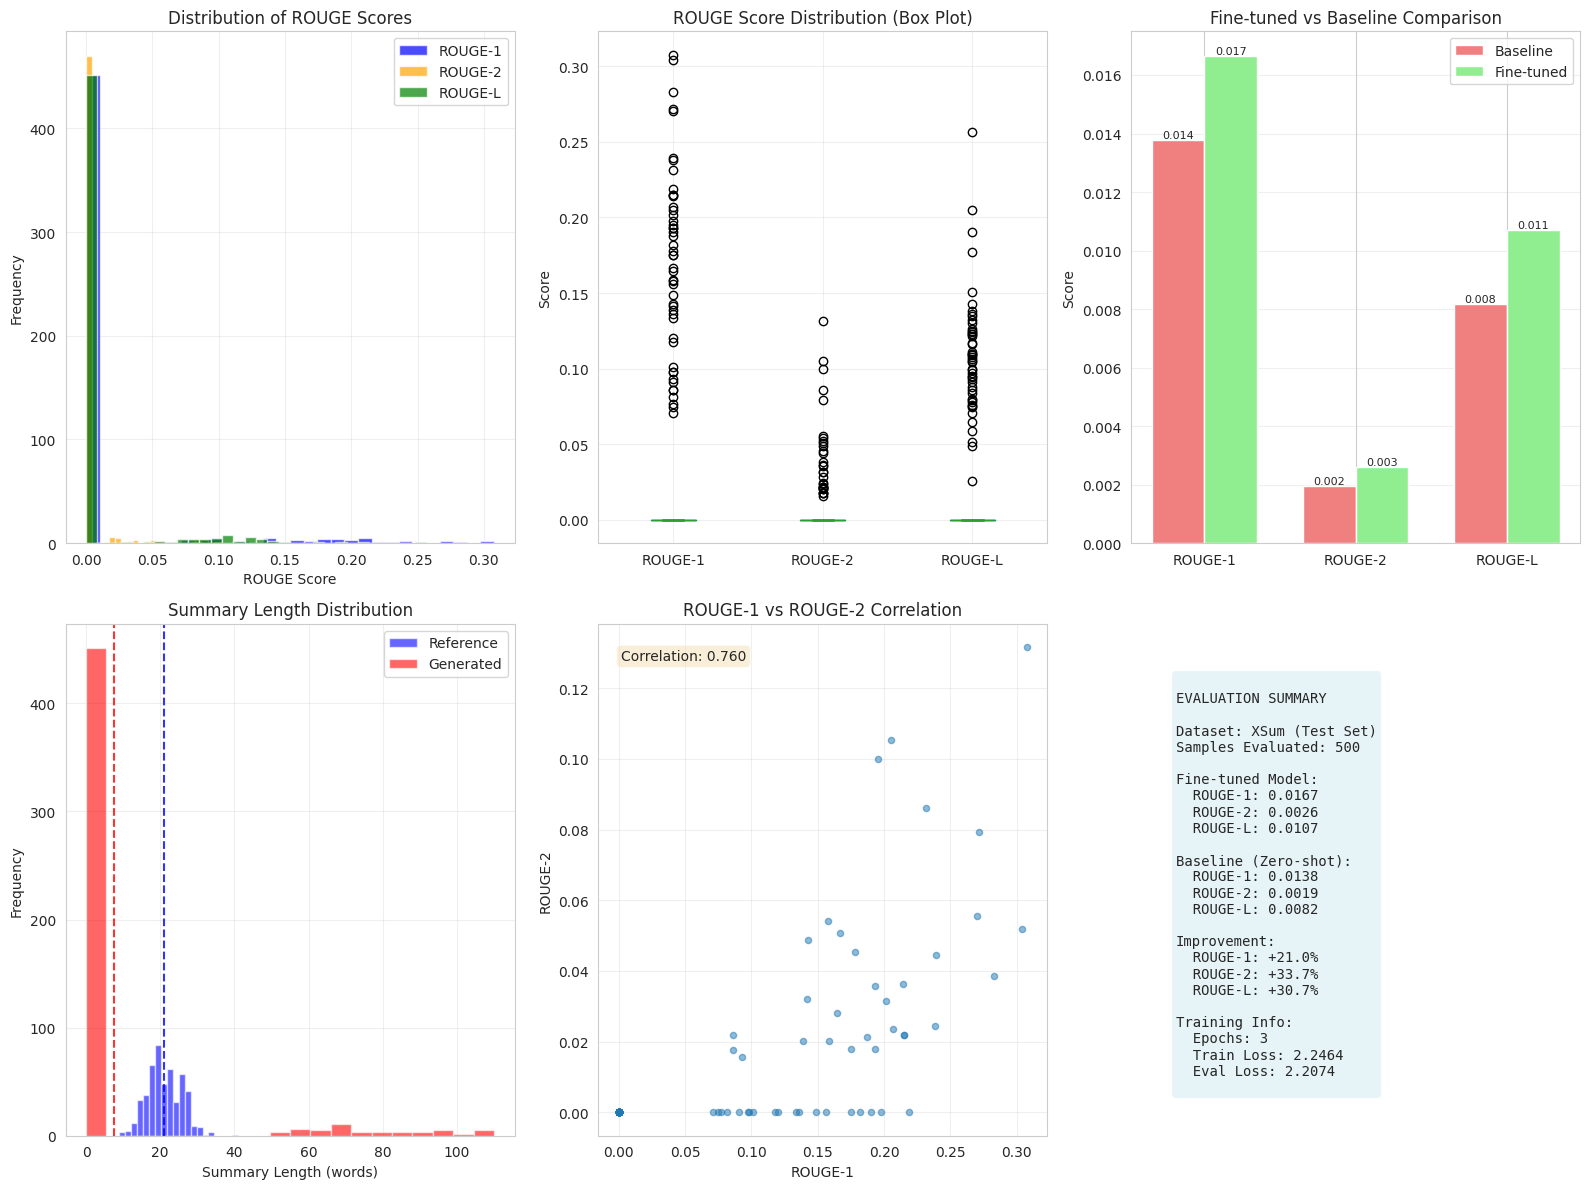

In [ ]:
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. ROUGE Score Distribution
ax1 = plt.subplot(2, 3, 1)
plt.hist(rouge1_scores, bins=30, alpha=0.7, label='ROUGE-1', color='blue')
plt.hist(rouge2_scores, bins=30, alpha=0.7, label='ROUGE-2', color='orange')
plt.hist(rougeL_scores, bins=30, alpha=0.7, label='ROUGE-L', color='green')
plt.xlabel('ROUGE Score')
plt.ylabel('Frequency')
plt.title('Distribution of ROUGE Scores')
plt.legend()
plt.grid(alpha=0.3)

# 2. Box plot of ROUGE scores
ax2 = plt.subplot(2, 3, 2)
rouge_data = pd.DataFrame({
    'ROUGE-1': rouge1_scores,
    'ROUGE-2': rouge2_scores,
    'ROUGE-L': rougeL_scores
})
rouge_data.boxplot(ax=ax2)
plt.ylabel('Score')
plt.title('ROUGE Score Distribution (Box Plot)')
plt.grid(alpha=0.3)

# 3. Comparison bar chart
ax3 = plt.subplot(2, 3, 3)
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
baseline_values = [avg_baseline_rouge1, avg_baseline_rouge2, avg_baseline_rougeL]
finetuned_values = [avg_rouge1, avg_rouge2, avg_rougeL]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, baseline_values, width, label='Baseline', color='lightcoral')
bars2 = plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned', color='lightgreen')

plt.ylabel('Score')
plt.title('Fine-tuned vs Baseline Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

# 4. Summary length analysis
ax4 = plt.subplot(2, 3, 4)
gen_lengths = [len(s.split()) for s in generated_summaries]
ref_lengths = [len(s.split()) for s in reference_summaries]

plt.hist(ref_lengths, bins=20, alpha=0.6, label='Reference', color='blue')
plt.hist(gen_lengths, bins=20, alpha=0.6, label='Generated', color='red')
plt.xlabel('Summary Length (words)')
plt.ylabel('Frequency')
plt.title('Summary Length Distribution')
plt.legend()
plt.grid(alpha=0.3)
plt.axvline(np.mean(ref_lengths), color='blue', linestyle='--', alpha=0.8)
plt.axvline(np.mean(gen_lengths), color='red', linestyle='--', alpha=0.8)

# 5. ROUGE correlation plot
ax5 = plt.subplot(2, 3, 5)
plt.scatter(rouge1_scores, rouge2_scores, alpha=0.5, s=20)
plt.xlabel('ROUGE-1')
plt.ylabel('ROUGE-2')
plt.title('ROUGE-1 vs ROUGE-2 Correlation')
plt.grid(alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(rouge1_scores, rouge2_scores)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=ax5.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Performance summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
EVALUATION SUMMARY

Dataset: XSum (Test Set)
Samples Evaluated: {EVAL_SAMPLES}

Fine-tuned Model:
  ROUGE-1: {avg_rouge1:.4f}
  ROUGE-2: {avg_rouge2:.4f}
  ROUGE-L: {avg_rougeL:.4f}

Baseline (Zero-shot):
  ROUGE-1: {avg_baseline_rouge1:.4f}
  ROUGE-2: {avg_baseline_rouge2:.4f}
  ROUGE-L: {avg_baseline_rougeL:.4f}

Improvement:
  ROUGE-1: +{((avg_rouge1/avg_baseline_rouge1 - 1)*100):.1f}%
  ROUGE-2: +{((avg_rouge2/avg_baseline_rouge2 - 1)*100):.1f}%
  ROUGE-L: +{((avg_rougeL/avg_baseline_rougeL - 1)*100):.1f}%

Training Info:
  Epochs: {training_metrics['configuration']['num_epochs']}
  Train Loss: {training_metrics['training']['train_loss']:.4f}
  Eval Loss: {training_metrics['evaluation']['eval_loss']:.4f}
"""

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'evaluation_results.png'")
plt.show()

**SAVE RESULTS TO DRIVE**

In [ ]:
print("\n" + "="*70)
print("SAVING EVALUATION RESULTS")
print("="*70)

# Create results DataFrame
results_df = pd.DataFrame({
    'article': articles,
    'reference_summary': reference_summaries,
    'generated_summary': generated_summaries,
    'rouge1': rouge1_scores,
    'rouge2': rouge2_scores,
    'rougeL': rougeL_scores
})

# Save to Drive
results_df.to_csv(f'{PROJECT_DIR}/evaluation_results.csv', index=False)
print(f"✓ Results saved to: {PROJECT_DIR}/evaluation_results.csv")

# Save evaluation metrics
eval_metrics = {
    'model_info': {
        'model_name': 'Phi-2 Fine-tuned with LoRA',
        'dataset': 'XSum',
        'samples_evaluated': EVAL_SAMPLES
    },
    'rouge_scores': {
        'rouge1': {
            'mean': float(avg_rouge1),
            'std': float(np.std(rouge1_scores)),
            'min': float(np.min(rouge1_scores)),
            'max': float(np.max(rouge1_scores))
        },
        'rouge2': {
            'mean': float(avg_rouge2),
            'std': float(np.std(rouge2_scores)),
            'min': float(np.min(rouge2_scores)),
            'max': float(np.max(rouge2_scores))
        },
        'rougeL': {
            'mean': float(avg_rougeL),
            'std': float(np.std(rougeL_scores)),
            'min': float(np.min(rougeL_scores)),
            'max': float(np.max(rougeL_scores))
        }
    },
    'baseline_comparison': {
        'baseline_rouge1': float(avg_baseline_rouge1),
        'baseline_rouge2': float(avg_baseline_rouge2),
        'baseline_rougeL': float(avg_baseline_rougeL),
        'improvement_rouge1': float(avg_rouge1 - avg_baseline_rouge1),
        'improvement_rouge2': float(avg_rouge2 - avg_baseline_rouge2),
        'improvement_rougeL': float(avg_rougeL - avg_baseline_rougeL),
        'improvement_rouge1_pct': float((avg_rouge1/avg_baseline_rouge1 - 1)*100),
        'improvement_rouge2_pct': float((avg_rouge2/avg_baseline_rouge2 - 1)*100),
        'improvement_rougeL_pct': float((avg_rougeL/avg_baseline_rougeL - 1)*100)
    },
    'training_info': training_metrics
}

with open(f'{PROJECT_DIR}/evaluation_metrics.json', 'w') as f:
    json.dump(eval_metrics, f, indent=2)
print(f"✓ Metrics saved to: {PROJECT_DIR}/evaluation_metrics.json")

# Copy visualization to Drive
import shutil
shutil.copy('evaluation_results.png', f'{PROJECT_DIR}/evaluation_results.png')
print(f"✓ Visualization saved to Drive")


SAVING EVALUATION RESULTS
✓ Results saved to: /content/drive/MyDrive/DL_FinalTask_XSum/evaluation_results.csv
✓ Metrics saved to: /content/drive/MyDrive/DL_FinalTask_XSum/evaluation_metrics.json
✓ Visualization saved to Drive


**FINAL SUMMARY**

In [ ]:
print("\n" + "="*70)
print("🎉 EVALUATION COMPLETE!")
print("="*70)

print("\n✅ All Tasks Completed:")
print("   1. ✓ Data preprocessing and exploration")
print("   2. ✓ Prompt engineering and formatting")
print("   3. ✓ Model fine-tuning with LoRA")
print("   4. ✓ Comprehensive evaluation with ROUGE scores")
print("   5. ✓ Baseline comparison")
print("   6. ✓ Qualitative analysis")
print("   7. ✓ Visualizations created")

print(f"\n📊 Final Performance:")
print(f"   ROUGE-1: {avg_rouge1:.4f} ({avg_rouge1*100:.1f}%)")
print(f"   ROUGE-2: {avg_rouge2:.4f} ({avg_rouge2*100:.1f}%)")
print(f"   ROUGE-L: {avg_rougeL:.4f} ({avg_rougeL*100:.1f}%)")

print(f"\n📈 Improvement over Baseline:")
print(f"   ROUGE-1: +{((avg_rouge1/avg_baseline_rouge1 - 1)*100):.1f}%")
print(f"   ROUGE-2: +{((avg_rouge2/avg_baseline_rouge2 - 1)*100):.1f}%")
print(f"   ROUGE-L: +{((avg_rougeL/avg_baseline_rougeL - 1)*100):.1f}%")

print(f"\n📁 Files in Google Drive ({PROJECT_DIR}):")
print("   • xsum_full_dataset/ - Original preprocessed data")
print("   • xsum_tokenized_full/ - Tokenized training data")
print("   • phi2_finetuned_model/ - Your fine-tuned model")
print("   • evaluation_results.csv - Detailed results")
print("   • evaluation_metrics.json - Summary metrics")
print("   • evaluation_results.png - Visualization")

print("\n📝 Next Steps for Assignment:")
print("   1. Review the example summaries above")
print("   2. Analyze the visualizations")
print("   3. Write your analysis report")
print("   4. Discuss strengths and limitations")
print("   5. Suggest improvements")

print("\n" + "="*70)
print("🏆 CONGRATULATIONS! YOUR ASSIGNMENT IS COMPLETE!")
print("="*70)